# Importy i definicje

In [24]:
import binance
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time
from datetime import datetime
import re
import matplotlib.pyplot as plt
from sqlalchemy import create_engine, MetaData
from sqlalchemy.orm import sessionmaker, scoped_session

client = binance.Client()

In [25]:
def get_data(asset):
    candles = client.get_klines(symbol=asset, interval='1m', limit = 10000)
    df = pd.DataFrame(candles, columns=['Open time', 'Open', 'High', 'Low', 'Close', 'Volume', 'Close time', 
									'Quote asset volume', 'Number of trades', 'Taker buy base asset volume', 
									'Taker buy quote asset volume', 'Ignore']).astype("float") # bo domyślnie to są stringi xd
    # Wzór na RSI kradziony z https://www.learnpythonwithrune.org/pandas-calculate-the-relative-strength-index-rsi-on-a-stock/
    delta = df['Close'].diff()
    up = delta.clip(lower=0)
    down = -1*delta.clip(upper=0)
    ema_up = up.ewm(com=13, adjust=False).mean()
    ema_down = down.ewm(com=13, adjust=False).mean()
    rs = ema_up/ema_down
    df['RSI'] = 100 - (100/(1 + rs))
    # Średnie kroczące 
    # Przykładowe długości okien https://www.investopedia.com/articles/active-trading/010116/perfect-moving-averages-day-trading.asp
    df["FMA"] = df["Close"].rolling(window=5).mean()
    df["SMA"] = df["Close"].rolling(window=13).mean()
    # Wyrzucamy pierwsze 14 dni żeby mieć wiarygodne wartości RSI
    df = df.iloc[14:]
    return df

def plot_data(symbol, df, transactions):
    # kradzione z https://python.plainenglish.io/a-simple-guide-to-plotly-for-plotting-financial-chart-54986c996682
    fig = make_subplots(specs=[[{"secondary_y": True}]])
    fig.add_trace(go.Candlestick(x=df['Close time'],
                    open=df['Open'],
                    high=df['High'],
                    low=df['Low'],
                    close=df['Close'], name=symbol))
    for i in range(38000, 41000, 100):
        fig.add_hline(y=i, line_width=0.1, fillcolor="red", opacity=0.9)
    fig.add_trace(go.Scatter(x = transactions['Time'], y = transactions['Price']))
    fig.update_layout(yaxis_range=[38000,41000])
    fig.show()

# def plot_data_transactions(transactions):
#     # kradzione z https://python.plainenglish.io/a-simple-guide-to-plotly-for-plotting-financial-chart-54986c996682
#     fig = make_subplots(specs=[[{"secondary_y": True}]])
#     # fig.add_trace(go.Candlestick(x=df['Close time'],
#     #                 open=df['Open'],
#     #                 high=df['High'],
#     #                 low=df['Low'],
#     #                 close=df['Close'], name=symbol))
#     fig.add_trace(go.Scatter(x = transactions['Time'], y = transactions['Price'], fillcolor = 'green'))
#     fig.add_trace(go.Scatter(x = transactions.loc[transactions['Type'] == 'BUY']['Time'], y = transactions.loc[transactions['Type'] == 'BUY']['Price'], fillcolor = 'green'))
#     fig.add_trace(go.Scatter(x = transactions.loc[transactions['Type'] == 'BUY']['Time'], y = transactions.loc[transactions['Type'] == 'SELL']['Price'], fillcolor = 'green'))
#     for i in range(38000, 41000, 100):
#         fig.add_hline(y=i, line_width=0.5, opacity=0.9)
#     fig.update_layout(yaxis_range=[40000,41000])
#     fig.show()

def plot_data_transactions(transactions):
    plt.figure(figsize = (20,10)) 
    transactions['Price'].plot(color = 'k', label= 'Price') 
    # data['FMA'].plot(color = 'green',label = 'FMA') 
    # data['SMA'].plot(color = 'red', label = 'SMA')

    plt.plot(transactions[transactions['Type'] == 'BUY'].index, 
             transactions[transactions['Type'] == 'BUY']['Price'], 
             '^', markersize = 10, color = 'g', label = 'BUY')

    plt.plot(transactions[transactions['Type'] == 'SELL'].index, 
             transactions[transactions['Type'] == 'SELL']['Price'], 
             'v', markersize = 10, color = 'r', label = 'SELL')

    for i in range(38000, 41000, 100):
        plt.axhline(y=i, color='black', linestyle='-', linewidth = 0.2, alpha = 0.5)

    plt.ylim([40000, 41000])
    plt.ylim(transactions['Price'].min(), transactions['Price'].max())

    legend = plt.legend(loc='upper center', shadow=True, fontsize='x-large')

    # Put a nicer background color on the legend.
    legend.get_frame().set_facecolor('lightcyan')

    # plt.plot(data[data['position'] == 'sell'].index, 
    #          data['SMA'][data['position'] == 'sell'], 
    #          'v', markersize = 5, color = 'r', label = 'sell')

# Wczytanie danych

In [26]:
transactions = pd.read_json('transactions.json').transpose()
transactions['Time'] = [x.timestamp()*1000 for x in transactions.index]
transactions = transactions.loc[transactions['Price'].notnull()]
transactions = transactions.loc[transactions['Time'] > 1651040438259.0872]

balance = pd.read_json('balance.json')

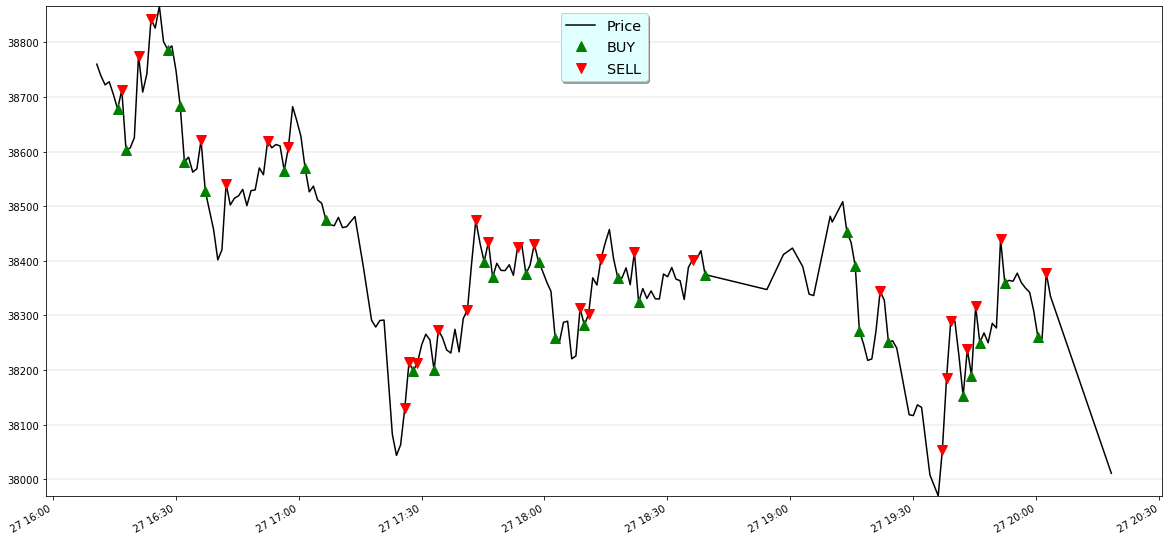

In [27]:
# plot_data("BTCUSDT", get_data("BTCUSDT").tail(100), testdf.tail(10))
# plot_data("BTCUSDT", get_data("BTCUSDT"), testdf)
plot_data_transactions(transactions.tail(200))

Czy hajs się zgadza?


In [28]:
balance_usdt = (balance.loc[balance['asset'] == 'USDT']['free'].values[0] +
(balance.loc[balance['asset'] == 'BTC']['free'].values[0] - 1)*transactions.iloc[-1]['Price'])

print('Stan konta początkowo: 10000 USDT')
print('Stan konta: ' + str(balance_usdt) + ' USDT')

print('Gratulacje! Zarobiłeś ' + str(round(balance_usdt - 10000, 2)) + ' USDT')

Stan konta początkowo: 10000 USDT
Stan konta: 9607.502125240004 USDT
Gratulacje! Zarobiłeś -392.5 USDT


In [29]:
print('Type: ' + 'BUY' + ' Symbol: ' 'test' + ' Quantity: ' + '2' + ' Price: ' + '2137' + 
                ' Time: ' + str(datetime.now()))

Type: BUY Symbol: test Quantity: 2 Price: 2137 Time: 2022-04-27 22:20:03.552977


In [30]:
datetime.now()

print('Type: ' + 'SELL' + 'Symbol: ' + 'symbol' + ' Quantity: ' + 'round(order_value/current_price, 4)' + ' Price: ' 'current_price' + 
' Time: ' + str(datetime.datetime.now()))

AttributeError: type object 'datetime.datetime' has no attribute 'datetime'